# `Setup`

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/alexanderries/aml_itu
MPS device found.


### `Config`

In [32]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `TinyVGG`

In [33]:
# IMG Transformations
transforms = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val': v2.Compose([
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.ToDtype(torch.float32, scale=True)])}



# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [34]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=transforms['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=transforms['val'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=transforms['val'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 14409
Lenght of val data: 3345
Lenght of val data: 4670


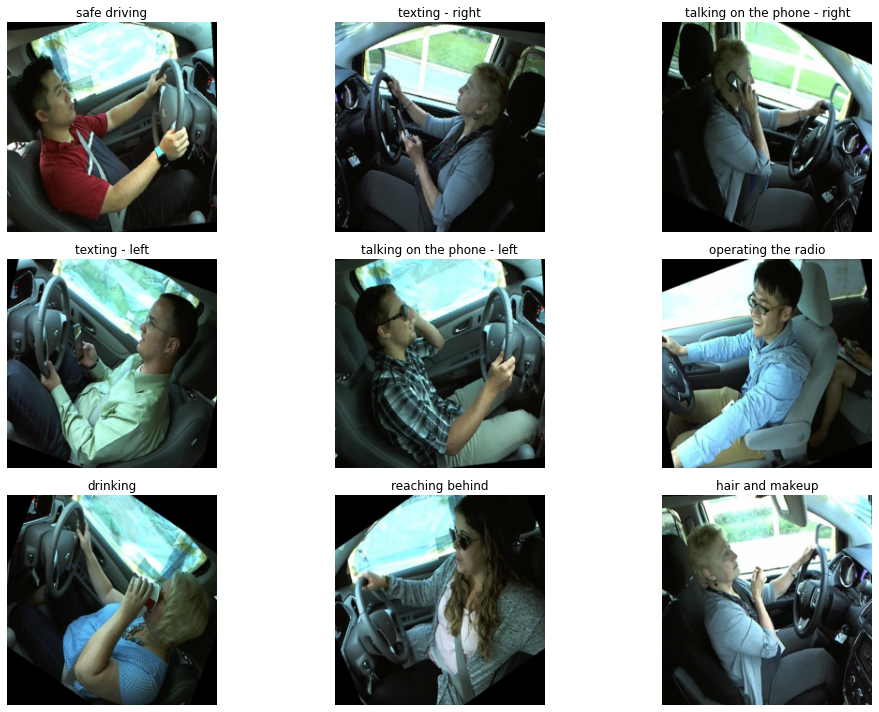

In [35]:
# Displaying training data including transformations
train_data.display_classes(id_to_class=True)

#### `Model`

In [36]:
''' A simple Convolution, Batch Normalization, and Activation Class'''

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
#------------------------------------------------------------------------------

''' Squeeze and Excitation Block '''

class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        
        y = self.se(x)
        
        return x * y
                                    
#------------------------------------------------------------------------------

''' Stochastic Depth Module'''

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
        
#-------------------------------------------------------------------------------

''' Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
    with Squeeze and Excitation Block and Stochastic Depth. 
'''

class MBConvN(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x
    

#----------------------------------------------------------------------------------------------

'''Efficient-net Class'''

class EfficientNet(nn.Module):
    
    '''Generic Efficient net class which takes width multiplier, Depth multiplier, and Survival Prob.'''
    
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [37]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

In [38]:
# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = 1., 1., 224, .5 # efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10)

In [39]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [40]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [32, 10]                  --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─ConvBnAct: 2-1                              [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                              [32, 32, 112, 112]        --
│    └─MBConvN: 2-2                                [32, 16, 112, 112]        --
│    │    └─Identity: 3-4                          [32, 32, 112, 112]        --
│    │    └─ConvBnAct: 3-5                         [32, 32, 112, 112]        352
│    │    └─SqueezeExcitation: 3-6                 [32, 32, 112, 112]        552
│    │    └─ConvBnAct: 3-7                         [32, 16, 112, 112]        544
│    └─MBConvN: 2-3            

#### `Training Methods`

In [41]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [42]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [43]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [44]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [45]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [46]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

In [47]:
# # Set random seeds
# torch.manual_seed(42)

# # Initialize Efficientnet model
# version = 'b0'
# width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
# dropout_rate = .5
# MODEL_NAME = 'EfficientNet_b0_AdamW'
# model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10)
# model = model.to(device) # Load model to device.

# # Setup loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# # Setup scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                     #    'min',
#                                                        factor=.1,
#                                                        patience=5,
#                                                     #    min_lr=1e-7,
#                                                        verbose=True)

# early_stopping = EarlyStopper(patience=5, min_delta=.03)

# # results
# results = train(model=model,
#                 train_dataloader=train_dataloader,
#                 validation_dataloader=val_dataloader,
#                 optimizer=optimizer,
#                 loss_fn=loss_fn,
#                 epochs=epochs,
#                 device=device,
#                 scheduler=scheduler,
#                 early_stopping=early_stopping,
#                 model_name=MODEL_NAME)

### Testing on Test Images

In [48]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    model.eval()
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

In [49]:
# test_predictions = test(model=model,
#                         dataloader=test_dataloader,
#                         device=device)

In [50]:
# best_model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10).to(device)
# best_model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/EfficientNet_b0_AdamW/EfficientNet_b0_AdamW_20231204_093524_epoch_5.pt'))

In [51]:
# best_predictions = test(model=best_model,
#                         dataloader=test_dataloader,
#                         device=device)

# Grad Cam Implementation

- inspired by: https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569
- more articles:
    - https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
    - https://arxiv.org/pdf/1610.02391.pdf <-- original article
- Requires Model Definition and Architecture

How to:
- Instantiate model
- Load model weights
- Put model in eval mode
- Identify last convolutional block/layer before Dense layer
- Apply grad_cam function

In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL
import random

# Global variables to store gradients and activations
gradients = None
activations = None

def backward_hook(module, inputs, outputs):
    global gradients
    gradients = outputs[0]  # Get the actual gradient tensor

def forward_hook(module, inputs, outputs):
    global activations
    activations = outputs
    
def grad_cam_test(model, img, layer, original_label=None, predicted_label=None, device='cpu'):
    """Function to generate Grad-CAM for a single image and a specified layer"""
    model.eval()
    img = img.to(device)

    # Register hooks on the specified layer
    layer.register_forward_hook(forward_hook)
    layer.register_full_backward_hook(backward_hook)

    # Forward pass
    with torch.enable_grad():
        img_input = img.unsqueeze(0).requires_grad_()
        prediction = model(img_input)
        prediction[:, prediction.argmax(1)].sum().backward()

        # Compute the heatmap
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(to_pil_image(img, mode='RGB'))
        title = 'Original Image'
        if original_label is not None:
            title += f'\nTrue Label: {original_label}'
        axs[0].set_title(title)
        axs[0].axis('off')

        # Plot heatmap with adjusted parameters or different colormap
        heatmap_detached = heatmap.cpu().detach().numpy()  # Detach and move to CPU
        axs[1].imshow(heatmap_detached, cmap='jet', interpolation='nearest')
        axs[1].set_title('Heatmap')
        axs[1].axis('off')

        # Plot Grad-CAM
        overlay = to_pil_image(heatmap.detach(), mode='F').resize(img.shape[1:3], resample=PIL.Image.BICUBIC)
        cmap = colormaps['jet']
        overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
        axs[2].imshow(to_pil_image(img, mode='RGB'))
        axs[2].imshow(overlay, alpha=0.4, interpolation='nearest')
        title = 'Grad-CAM'
        if predicted_label is not None:
            title += f'\nPredicted Label: {predicted_label}'
        axs[2].set_title(title)
        axs[2].axis('off')

        plt.show()


In [53]:
model_path = "/Users/alexanderries/aml_itu/outputs/test_grad_cam/EfficientNet_b0_AdamW_20231204_103512_epoch_10.pt"

# instantiate model
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10).to('cpu')

# load model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# model in evaluation mode
model.eval()

EfficientNet(
  (features): Sequential(
    (0): ConvBnAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (1): MBConvN(
      (expand): Identity()
      (depthwise_conv): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (se): SqueezeExcitation(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): SiLU()
          (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (pointwise_conv): ConvBnAct(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(

In [54]:
# Define layer to use for Grad-CAM
layer = getattr(model, 'features')[-1]

### Test on 10 random images from Test Set

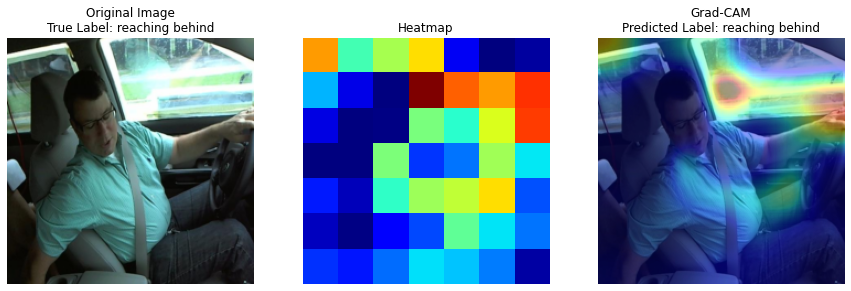

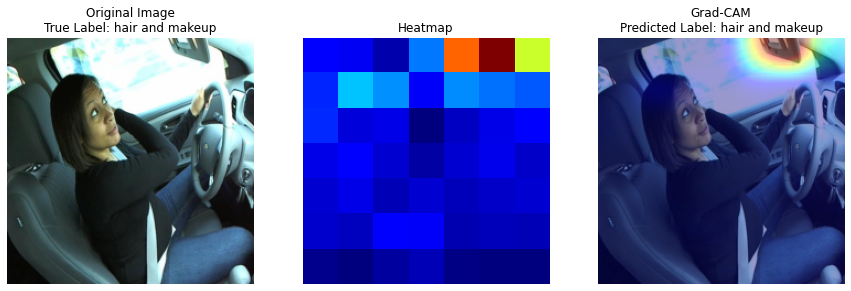

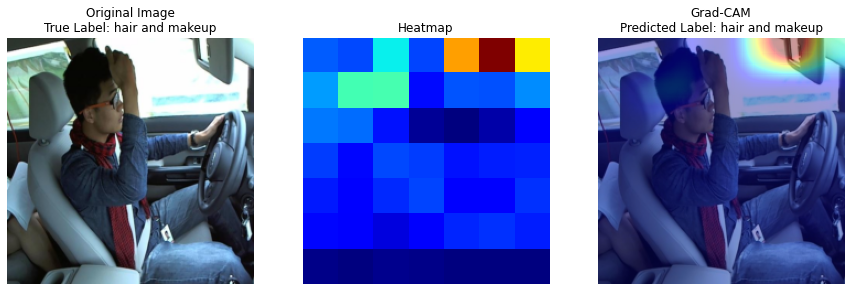

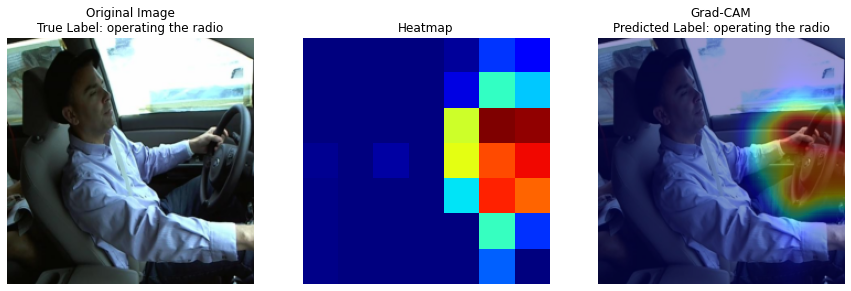

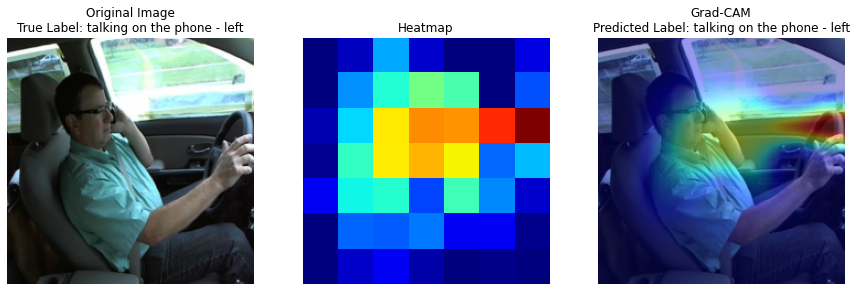

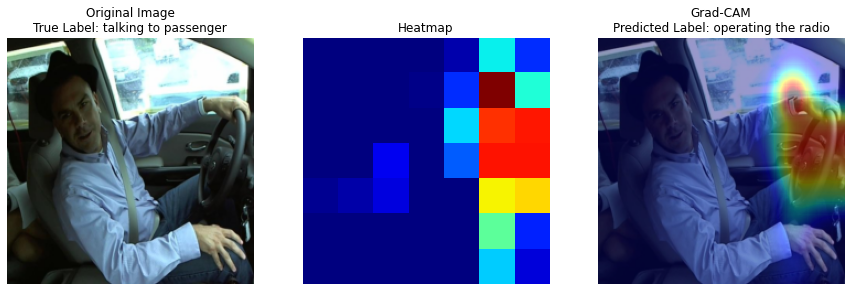

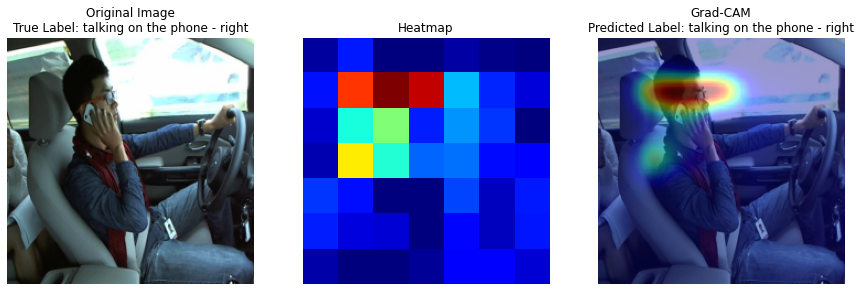

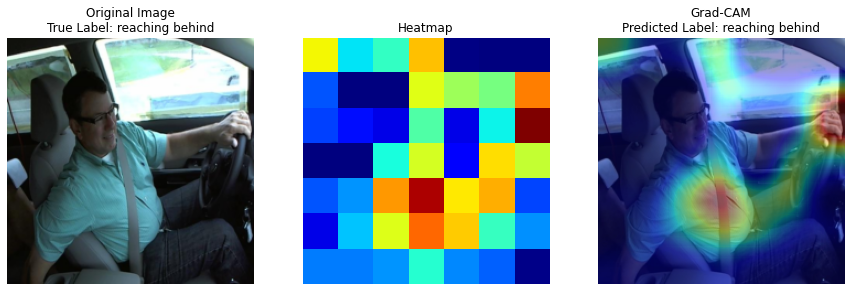

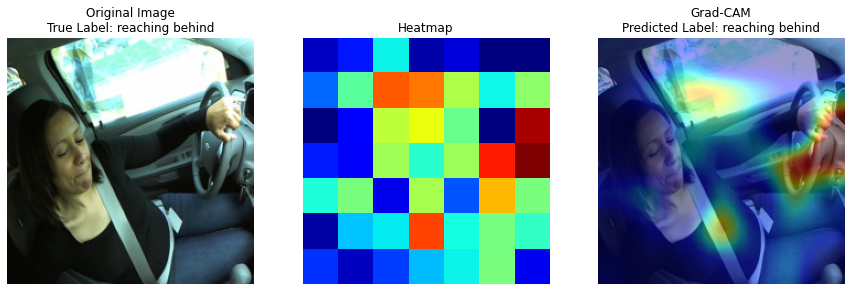

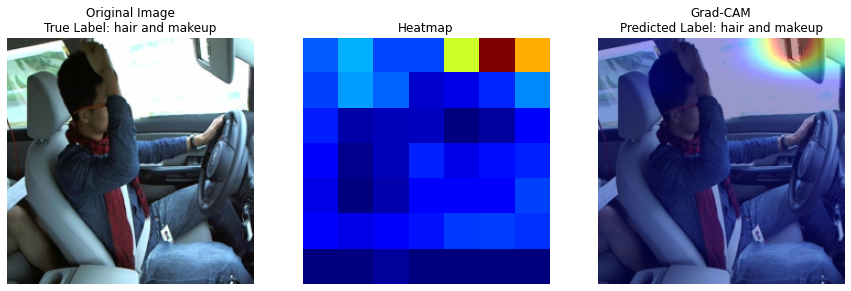

In [55]:
# Assuming test_dataloader is your DataLoader instance
random_data = []
for imgs, labels in test_dataloader:
    random_data.extend(zip(imgs, labels))
    if len(random_data) >= 10:
        break

# Now random_data contains at least 10 (image, label) pairs
# We select 10 pairs randomly
selected_data = random.sample(random_data, 10)

# Apply grad_cam_test on each of these images
for img, original_label in selected_data:
    img_input = img.unsqueeze(0)
    with torch.no_grad():
        prediction = model(img_input.to('cpu'))
    predicted_label = prediction.argmax(1).item()  # Assuming single output label

    # Convert labels to actual names if necessary, e.g., using a label map
    original_label_name = config['dataset']['class_mapping'][f'c{original_label}']  # Replace label_map with your label mapping
    predicted_label_name = config['dataset']['class_mapping'][f'c{predicted_label}'] # Replace label_map with your label mapping

    grad_cam_test(model, img, layer, original_label_name, predicted_label_name)
